In [1]:
!pip install fake-useragent

  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-cp37-none-any.whl size=13485 sha256=2ec3adcc1e52c9dac1261350d30c0d579bc4f13d703c91b8f86fccfb98e251f8
  Stored in directory: /root/.cache/pip/wheels/5e/63/09/d1dc15179f175357d3f5c00cbffbac37f9e8690d80545143ff
Successfully built fake-useragent


In [2]:
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
import requests

import numpy as np
import pandas as pd

In [3]:
ua = UserAgent()
header = {'user-agent': ua.chrome}

In [4]:
def get_standings_data(season):
  mpl_link = 'https://id-mpl.com/'+season
  mpl_res = requests.get(mpl_link, headers=header)
  if mpl_res.status_code == 200:
    mpl_html = mpl_res.text
    mpl_soup = BeautifulSoup(mpl_html, 'lxml')
    mpl_page = mpl_soup.find('ul', {'class':'tab-filters mt10'}).find('li')

    if mpl_page.text.strip() == 'regular-season':
      mpl_tbl = mpl_soup.find('div', {'class':'col-md-12'}).find('table', {'class':'table-standings'})
      mpl_tbl_cols = [x.text.strip() for x in mpl_tbl.find('thead').find_all('th')]
      
      mpl_data = []
      for standings in mpl_tbl.find('tbody').find_all('tr'):
        standings_data = []
        for standing in standings.find_all('td'):
          rows = standing.text.strip().replace(' ','').split()
          standings_data.append(rows)
        
        team_name = standings_data[0][2]
        match = ''.join(standings_data[1])
        match_rate = standings_data[2][0]
        game = ''.join(standings_data[3])
        game_rate = standings_data[4][0]
        point = standings_data[5][0]
        mpl_data.append([team_name, match, match_rate, game, game_rate, point])

  return mpl_tbl_cols, mpl_data


In [5]:
season = ['s4','s5','s6']
for s in season:
  cols, stands = get_standings_data(s)
  df_mpl = pd.DataFrame(stands, columns=cols)
  df_mpl.to_csv(s + '_mpl_regular_data.csv', index=False)

In [6]:
def get_team_statistics(season):
  team_link = 'https://id-mpl.com/'+season+'/team-statistic'
  team_res = requests.get(team_link, headers=header)
  if team_res.status_code == 200:
    team_html = team_res.text
    team_soup = BeautifulSoup(team_html, 'lxml')
    team_tabs = team_soup.find('div',{'class':'tab-content'})
    team_tbl_cols = [i.text.strip() for i in team_tabs.find('thead').find_all('th', {'class':'sticky-header'})]

    team_tabs_data = {}
    for tabs in team_tabs.find_all('div',{'class':'cup-body'}):
      tab = tabs.get('id').strip()
      team_data = []
      for team_stats in tabs.find('tbody').find_all('tr'):
        stats_data = []
        for team in team_stats.find_all('td'):
          rows = team.text.strip()
          stats_data.append(rows)
        team_data.append(stats_data)
      team_tabs_data[tab] = team_data

  return team_tbl_cols, team_tabs_data

    


In [7]:
for s in season:
  cols, teams = get_team_statistics(s)
  for k, v in teams.items():
    df_team = pd.DataFrame(v, columns=cols)
    file_team = s + '_team_stats_' + k.split('-')[1] + '.csv'
    df_team.to_csv(file_team, index=False)

In [8]:
def get_player_statistics(season):
  player_link = 'https://id-mpl.com/'+season+'/player-statistic'
  player_res = requests.get(player_link, headers=header)
  if player_res.status_code == 200:
    player_html = player_res.text
    player_soup = BeautifulSoup(player_html, 'lxml')
    player_tabs = player_soup.find('div',{'class':'tab-content'})
    player_tbl_cols = [col.text.strip() for col in player_tabs.find('thead').find_all('tr')[1].find_all('th')]

    player_tabs_data = {}
    for tabs in player_tabs.find_all('div',{'class':'cup-body'}):
      tab = tabs.get('id').strip()
      player_data = []
      for player_stats in tabs.find('tbody').find_all('tr'):
        stats_data = []
        for player in player_stats.find_all('td'):
          rows = player.text.strip()
          stats_data.append(rows)
        player_data.append(stats_data)

      if len(player_data) == 0:
        player_tabs_data[tab] = [np.repeat('N/A', len(player_tbl_cols)).tolist()]
      else:
        player_tabs_data[tab] = player_data
  
  return player_tbl_cols, player_tabs_data

In [9]:
for s in season:
  c, p = get_player_statistics(s)
  for m, n in p.items():
    df_player = pd.DataFrame(n, columns=c)
    file_player = s + '_player_stats_' + m.split('-')[1] + '.csv'
    df_player.to_csv(file_player, index=False)

In [11]:
mpl_all = []
team_all = []
player_all = []

for s in season:
  c1, data1 = get_standings_data(s)
  df1 = pd.DataFrame(data1, columns=c1)
  df1['season'] = s.upper()
  mpl_all.append(df1)

  c2, data2 = get_team_statistics(s)
  df2_all = []
  for k1, v1 in data2.items():
    df2 = pd.DataFrame(v1, columns=c2)
    df2['standings'] = k1.replace('-',' ')
    df2['season'] = s.upper()
    df2_all.append(df2)
  team_all.append(pd.concat(df2_all))

  c3, data3 = get_player_statistics(s)
  df3_all = []
  for k2, v2 in data3.items():
    df3 = pd.DataFrame(v2, columns=c3)
    df3['standings'] = k2.replace('-',' ')
    df3['season'] = s.upper()
    df3_all.append(df3)
  player_all.append(pd.concat(df3_all))


In [32]:
df_mpl_all = pd.concat(mpl_all).reset_index(drop=True)
df_team_all = pd.concat(team_all).reset_index(drop=True)
df_player_all = pd.concat(player_all).reset_index(drop=True)

In [33]:
print(df_mpl_all.shape)
print(df_mpl_all.info())
df_mpl_all.head()

(24, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TEAM         24 non-null     object
 1   MATCH W-L    24 non-null     object
 2   MATCH RATE   24 non-null     object
 3   GAME W-L     24 non-null     object
 4   GAME RATE    24 non-null     object
 5   AGG. POINTS  24 non-null     object
 6   season       24 non-null     object
dtypes: object(7)
memory usage: 1.4+ KB
None


,TEAM,MATCH W-L,MATCH RATE,GAME W-L,GAME RATE,AGG. POINTS,season
0,EVOS,11-3,79%,23-9,72%,+14,S4
1,RRQ,10-4,71%,22-13,63%,+9,S4
2,AE,10-4,71%,21-15,58%,+6,S4
3,AURA,7-7,50%,17-16,52%,+1,S4
4,BTR,6-8,43%,16-18,47%,-2,S4


In [34]:
print(df_team_all.shape)
print(df_team_all.info())
df_team_all.head()

(44, 19)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44 entries, 0 to 43
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   TEAM          44 non-null     object
 1   KPG           44 non-null     object
 2   DPG           44 non-null     object
 3   APG           44 non-null     object
 4   KDA           44 non-null     object
 5   AVG           44 non-null     object
 6   GPM (Diff)    44 non-null     object
 7   GPM           44 non-null     object
 8   Turtle        44 non-null     object
 9   Lord          44 non-null     object
 10  Kills         14 non-null     object
 11  Deaths        14 non-null     object
 12  Assists       14 non-null     object
 13  standings     44 non-null     object
 14  season        44 non-null     object
 15  Games         30 non-null     object
 16  Total Kill    30 non-null     object
 17  Total Death   30 non-null     object
 18  Total Assist  30 non-null     object
dtypes

,TEAM,KPG,DPG,APG,KDA,AVG,GPM (Diff),GPM,Turtle,Lord,Kills,Deaths,Assists,standings,season,Games,Total Kill,Total Death,Total Assist
0,AE,15.75,14.75,32.86,3.3,14.50,1446,620,1.3,0.6,567,531,1183,standing regular season,S4,NaN,NaN,NaN,NaN
1,AURA,13.67,13.22,31.41,3.4,14.40,-330,589,1.2,0.6,424,410,974,standing regular season,S4,NaN,NaN,NaN,NaN
2,BTR,12.46,12.38,28.56,3.3,12.41,-1086,599,1.2,0.4,399,401,914,standing regular season,S4,NaN,NaN,NaN,NaN
3,EVOS,14.4,12.75,30.06,3.5,14.16,4264,641,1.3,0.8,461,408,962,standing regular season,S4,NaN,NaN,NaN,NaN
4,GEEK,11.52,14.91,23.52,2.4,14.21,-4747,562,1.1,0.5,395,507,800,standing regular season,S4,NaN,NaN,NaN,NaN


In [35]:
print(df_player_all.shape)
print(df_player_all.info())
df_player_all.head()

(246, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   PLAYER      246 non-null    object
 1   Games       246 non-null    object
 2   KPG         246 non-null    object
 3   DPG         246 non-null    object
 4   APG         246 non-null    object
 5   KDA         246 non-null    object
 6   GPM         246 non-null    object
 7   KP %        246 non-null    object
 8   DPM         246 non-null    object
 9   TANKED      57 non-null     object
 10  Kills       246 non-null    object
 11  Deaths      246 non-null    object
 12  Assists     246 non-null    object
 13  standings   246 non-null    object
 14  season      246 non-null    object
 15  TANKED/MIN  189 non-null    object
dtypes: object(16)
memory usage: 30.9+ KB
None


,PLAYER,Games,KPG,DPG,APG,KDA,GPM,KP %,DPM,TANKED,Kills,Deaths,Assists,standings,season,TANKED/MIN
0,Arss,6,2,3.16,4.16,1.9,590,46%,1475,4163,12,19,25,standing regular season,S4,NaN
1,Maungzy,30,5.23,3.03,6.9,4,750,63%,3021,2399,157,91,207,standing regular season,S4,NaN
2,LeoMurphy,30,1.13,4.26,10.2,2.7,522,59%,1223,5747,34,128,306,standing regular season,S4,NaN
3,Caesius,30,2.33,3.86,9.16,3,526,59%,1748,4912,70,116,275,standing regular season,S4,NaN
4,Rekt,27,3.7,2.22,7.4,5,772,64%,3239,2055,100,60,200,standing regular season,S4,NaN


In [36]:
df_mpl_all.fillna(0, inplace=True)
df_mpl_all.columns = [col.upper() for col in df_mpl_all.columns]
df_team_all.fillna(0, inplace=True)
df_team_all.columns = [col.upper() for col in df_team_all.columns]
df_player_all.fillna(0, inplace=True)
df_player_all.columns = [col.upper() for col in df_player_all.columns]

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
df_mpl_all['MATCH WON'] = df_mpl_all['MATCH W-L'].apply(lambda x: x.split('-')[0]).astype('int')
df_mpl_all['MATCH LOSE'] = df_mpl_all['MATCH W-L'].apply(lambda x: x.split('-')[1]).astype('int')
df_mpl_all['MATCH RATE'] = df_mpl_all['MATCH RATE'].str.replace('%','').astype('int') / 100
df_mpl_all['GAME WON'] = df_mpl_all['GAME W-L'].apply(lambda x: x.split('-')[0]).astype('int')
df_mpl_all['GAME LOSE'] = df_mpl_all['GAME W-L'].apply(lambda x: x.split('-')[1]).astype('int')
df_mpl_all['GAME RATE'] = df_mpl_all['GAME RATE'].str.replace('%','').astype('int') / 100
df_mpl_all['AGG. POINTS'] = df_mpl_all['AGG. POINTS'].str.replace('+','').astype('int')
df_mpl_all['SEASON'] = df_mpl_all['SEASON'].str.replace('S','SEASON ')
df_mpl_all.drop(['MATCH W-L', 'GAME W-L'], axis=1, inplace=True)
df_mpl_all.head()

,TEAM,MATCH RATE,GAME RATE,AGG. POINTS,SEASON,MATCH WON,MATCH LOSE,GAME WON,GAME LOSE
0,EVOS,0.79,0.72,14,SEASON 4,11,3,23,9
1,RRQ,0.71,0.63,9,SEASON 4,10,4,22,13
2,AE,0.71,0.58,6,SEASON 4,10,4,21,15
3,AURA,0.50,0.52,1,SEASON 4,7,7,17,16
4,BTR,0.43,0.47,-2,SEASON 4,6,8,16,18


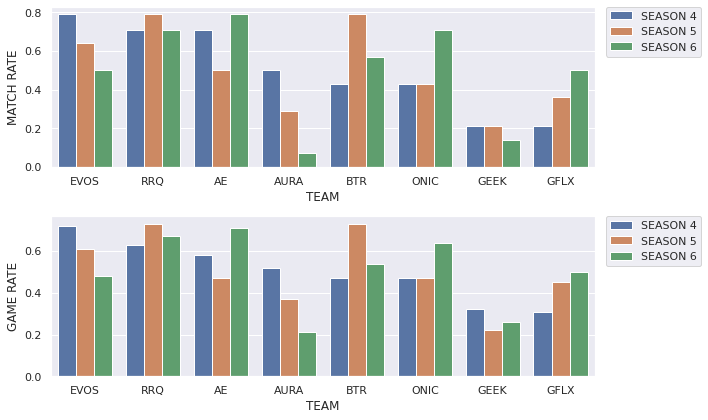

In [48]:
sns.set()
plt.figure(figsize=(10,6))
plt.subplot(211)
sns.barplot(data=df_mpl_all, x='TEAM', y='MATCH RATE', hue='SEASON')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.subplot(212)
sns.barplot(data=df_mpl_all, x='TEAM', y='GAME RATE', hue='SEASON')
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()

In [49]:
pd.to_numeric(df_team_all).head()

TypeError: ignored